## Actor Critic with GAE Implementation:

Here I will solve the Reacher 20, novis environment (from udacity second project). The reacher environment can be found [here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher_Linux_NoVis.zip).

Source: [https://github.com/higgsfield/RL-Adventure-2/blob/master/2.gae.ipynb](https://github.com/higgsfield/RL-Adventure-2/blob/master/2.gae.ipynb)

A2C with GAE basic pseudocode: 
- The agent takes NUM_STEPS in the environment, collecting rewards, state values, log probability of actions (log of policy) and terminal states
- Using the collected values, the agent computes GAE values
- advantages is calculated using: gae_returns - values 
- actor loss is calculated using: -(log_probs * advantages)  
- critic loss is calculated using: advantages ** 2
- losses are backpropagated to train the network

### 1. Imports

In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.distributions.normal import Normal
from unityagents import UnityEnvironment

### 2. Define Policy Network

Very simple fully connected neural network.

In [2]:
def init_weights(m):
    """ Initializes the weights and bias values of the Linear layers in the network """

    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)


class A2CNetwork(nn.Module):
    def __init__(self, state_size, action_size, std=0.0):
        super(A2CNetwork, self).__init__()

        # the critic network, it's output represents the state value for baseline
        self.critic = nn.Sequential(
            nn.Linear(state_size, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1)
        )

        # the actor network
        self.actor = nn.Sequential(
            nn.Linear(state_size, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, action_size),
        )
        
        # value of log_std will also be updated by gradient update
        self.log_std = nn.Parameter(torch.ones(1, action_size) * std)

        self.apply(init_weights)

    def forward(self, x):
        """ Returns distributions of actions and state value for input state """

        value = self.critic(x)
        mu = torch.tanh(self.actor(x))

        # calculating the standard deviation for the normal distribution
        # if self.log_std is zeros tensor, then std is ones tensor
        std = self.log_std.exp().expand_as(mu)

        # creating a normal distribution using mu and std
        # using this normal distribution (dist), the action value will be sampled
        dist = Normal(mu, std)

        return dist, value

### 3. Define Agent 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper-parameters:
NUM_STEPS = 10  # number of steps in rollout
LEARNING_RATE = 1e-4  # learning rate for the optimizer
OPTIMIZER_EPS = 1e-3  # default eps value for optimizer might be too low for converging


class ReacherAgent:
    """ The ReacherAgent class is responsible for interacting with the reacher environment and
        teaching the neural network (model) to take appropriate actions based on states

        This class is based on codes found here: 
        https://github.com/higgsfield/RL-Adventure-2/blob/master/2.gae.ipynb
        """

    def __init__(self, num_inputs, num_outputs, env, brain_name, num_agents):
        """Initialize an ReacherAgent object.

        Params
        ======
            num_inputs (int): dimension of each state
            num_outputs (int): dimension of each action
            env: the reacher environment object
            brain_name: reacher environment brain name
            num_agents: number of agents in reacher environment
        """

        self.model = A2CNetwork(num_inputs, num_outputs).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE, eps=OPTIMIZER_EPS)
        self.env = env
        self.brain = brain_name
        self.num_agents = num_agents

        # Initial state is stored in self.state. The states are normalized by dividing by 10.0
        env_info = self.env.reset(train_mode=True)[self.brain]
        self.state = env_info.vector_observations / 10.0

        self.scores = np.zeros(self.num_agents)  # scores keeps track of the env rewards

    def compute_gae(self, next_value, rewards, masks, values, gamma=0.99, tau=0.95):
        """ Returns the GAE (Generalized advantage estimation) value for a rollout, check 
        https://raw.githubusercontent.com/fahimfss/ProjectReacher/master/images_videos/compute_gae.png 
        for understanding how this method works

        Params
        ======
            next_value: state value of the the last state in rollout
            rewards: reward values during rollout
            masks: terminal state masks of each state in rollout (1 means that state is terminal)
            values: state values of each state in rollout
            gamma: discount rate
            tau: exponentially decaying factor for calculating GAE
        """

        values = values + [next_value]
        gae = 0
        returns = []
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
            gae = delta + gamma * tau * masks[step] * gae
            returns.insert(0, gae + values[step])
        return returns

    def step(self):
        """ step method does a NUM_STEPS rollout in the environment and updates the neural network (model)

            :returns
            The episode number and the mean score of agents in that episode if an episode ends in rollout
        """

        log_probs = []          # array to store log probabilities of each action in rollout
        values = []             # array to store state values (from model) of each state in rollout
        rewards = []            # array to store reward values for each step in rollout (provided by env)
        masks = []              # array to store terminal state flags for each state in rollout
        # Size of all four arrays after rollout: [NUM_STEPS, NUM_AGENTS]

        entropy = 0                         # entropy term to encourage exploration

        ret = None

        for _ in range(NUM_STEPS):          # NUM_STEPS rollout

            # Select action using the current state
            state = torch.FloatTensor(self.state).to(device)
            # the model returns a normal distribution for action value, and V(s)
            dist, value = self.model(state)     
            # action is sampled from the distribution and clipped in range [-1, 1]
            action = dist.sample().clamp(-1, 1)   
            action_np = action.cpu().numpy()

            env_info = self.env.step(action_np)[self.brain]      # action is applied in the env
            next_state = env_info.vector_observations / 10.0     # next_state is normalized by dividing by 10.0
            reward = np.asarray(env_info.rewards) * 20.0         # rewards are amplified by multiplying by 20
            done = np.array(env_info.local_done, dtype=int)      # done (terminal) flags are created

            self.scores += env_info.rewards      # actual reward values are added to score

            log_prob = dist.log_prob(action)
            entropy += dist.entropy().mean()

            # related values are added to the arrays
            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
            masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))

            self.state = next_state

            if np.any(done):    # for the given env, all the 20 environments terminate on the same frame
                env_info = self.env.reset(train_mode=True)[self.brain]    # reset the env
                self.state = env_info.vector_observations
                # prepare return value, which is the mean of actual scores
                ret = self.scores.mean()                      
                self.scores = np.zeros(self.num_agents)       # reset scores

        # state value of the last state is calculated using the neural network (model)

        # print("entropy", entropy)
        # print("std", self.model.log_std)

        next_state = torch.FloatTensor(next_state).to(device)
        _, next_value = self.model(next_state)

        # using the prepared arrays, the return values are calculated
        returns = self.compute_gae(next_value, rewards, masks, values)

        # convert arrays to torch tensors
        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        # calculate the advantage value
        advantage = returns - values

        # calculate actor loss (negative because of gradient ascend)
        actor_loss = -(log_probs * advantage.detach()).mean()

        # calculate critic loss
        critic_loss = advantage.pow(2).mean()

        # calculate total loss
        loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy

        # calculate gradients and update the neural network (model)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return ret

    def act(self, state):
        # given a state, returns the corresponding action

        state = state / 10.0
        state = torch.FloatTensor(state).to(device)
        dist, value = self.model(state)  # the model returns a normal distribution for action value, and V(s)
        # action is sampled from the distribution and clipped in range [-1, 1]
        action = dist.sample().clamp(-1, 1)  
        action_np = action.cpu().numpy()
        return action_np


### 4. Environment Sovler

In [4]:
ENV_PATH = "/home/fahim/Downloads/Reacher20_novis/Reacher.x86_64"   # path to the reacher20 env
SCORE_LIMIT = 32                              # mean score of 100 episodes to reach

# initialize the environment
env = UnityEnvironment(file_name=ENV_PATH)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
num_outputs = brain.vector_action_space_size
print('Size of each action:', num_outputs)

# examine the state space
states = env_info.vector_observations
num_inputs = states.shape[1]

scores = []  # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores

# create the ReacherAgent object
agent = ReacherAgent(num_inputs, num_outputs, env, brain_name, num_agents)
i_episode = 0

while True:  # train until the SCORE_LIMIT is not reached
    reward = agent.step()
    if reward is not None:
        scores.append(reward)
        scores_window.append(reward)
        score_mean_100 = np.mean(scores_window)
        print('\rEpisode {}\tAverage Score: {:.10f}'.format(i_episode, score_mean_100), end="")

        if i_episode > 0 and i_episode % 100 == 0:
            print()

        # finish training once score limit is reached
        if score_mean_100 > SCORE_LIMIT:
            break

        i_episode += 1
    

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
Episode 100	Average Score: 4.7773448932
Episode 200	Average Score: 30.5125293180
Episode 212	Average Score: 32.0615792834

### 5. Rewards plot

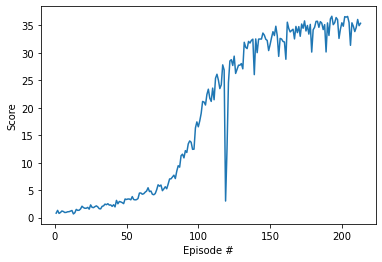

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()